<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# yahoo finance
import yfinance as yf
# personal scripts
import wrangle as w
# prophet model
from prophet import Prophet
# dataframes & matrices
import pandas as pd
import numpy as np
# stats and eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
# viz
import seaborn as sns
import matplotlib.pyplot as plt
# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
# warnings
import warnings
warnings.filterwarnings("ignore")
# ignore cmdstanpy
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
# for timing hyperparameter runing loop
from timeit import default_timer as timer
import time



In [2]:
# Personal for saving my data on to my Google Drive

# from google.colab import drive
# drive.mount('drive')

# Acquiring Eth-USD df

In [3]:
eth_usd = yf.Ticker("eth-usd")

In [4]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1656.7212
7,open,1656.7212
8,dayLow,1629.4266
9,dayHigh,1656.7212


## <font color='red'>Prior to selecting **3 months** of data, **21 months** was used and price of ethereum has dramatically decreased to be able to get an accurate prediction for a 4 hour time mark </font>

In [5]:
eth = eth_usd.history(period='3mo',interval='1h')

In [6]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


cp: cannot create regular file 'drive/My Drive/': No such file or directory


# Preparing Eth

In [7]:
eth = w.prepare_eth(eth)

# Exploring Eth

<Axes: xlabel='Datetime'>

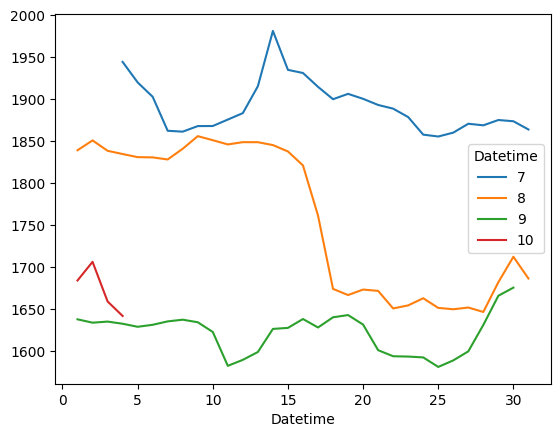

In [8]:
eth.groupby([eth.index.day,eth.index.month])['close'].mean().unstack().plot()

<Axes: xlabel='month'>

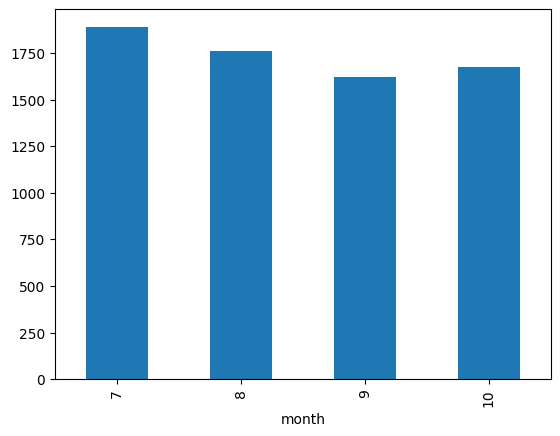

In [9]:
eth.groupby('month')['close'].mean().plot(kind='bar')

KeyboardInterrupt: ignored

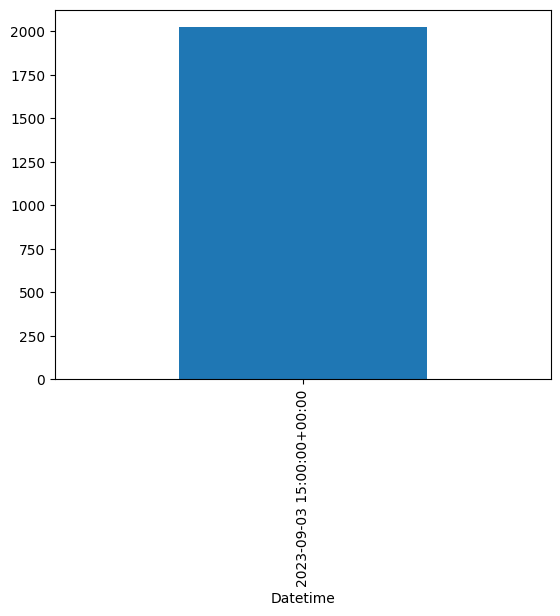

In [61]:
eth.resample('H').plot(kind='bar')

<Axes: xlabel='Datetime'>

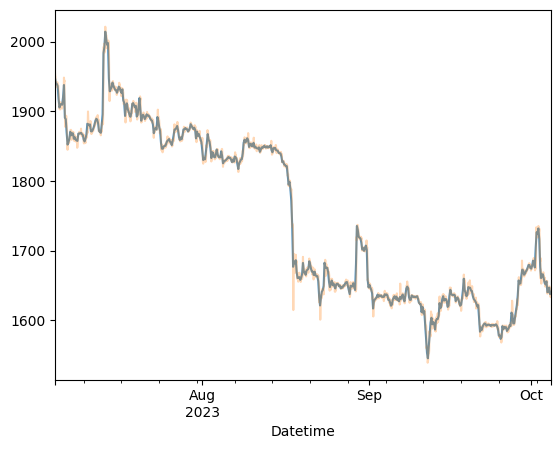

In [11]:
eth.close.resample('4h').mean().plot(alpha=.8)
eth.close.resample('1h').mean().plot(alpha=.3)

# Split

### Humanly determined
-- \
Using **90%** *train* and **10%** *test* \

<font color='blue'>This is determined since the price predicted is only on a 4-hour basis <font>

In [12]:
train_size = int(eth.shape[0] * .9)
test_size = int(eth.shape[0] * .1)

test_end_index = train_size + test_size


In [13]:
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

In [14]:
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (1988,), Test shape: (220,) , Eth shape: (2209, 9)


In [15]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [16]:
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')
train_model_fit = train_model.copy()

## Split using SKLearn (Did not use)

In [17]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [18]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Finding Baselines
  - Last Observed Value
  - Simple Average
  - Moving Average

In [19]:
def metrics_dataframe(model,RMSE):
    '''
    Keep track and automatically append data to compare models.
    '''
    metrics_df = pd.DataFrame(data=[
            {
                'model':model,
                'rmse':RMSE
            }
            ])
    return metrics_df

def save_metrics(df, model, RMSE):
    df.loc[len(df)] = [model, RMSE]
    df = df[~df.duplicated('model')]
    return df

## Last Observed

In [20]:
# last item in close
last_close = train[-1:][0]

yhat_df = pd.DataFrame(
    {'close': [last_close]},
    index=test_model.index)



In [21]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.close))

In [22]:
metrics_df = metrics_dataframe(model = 'last-observed' ,RMSE=score)

In [23]:
metrics_df

,model,rmse
0,last-observed,88.824292


## Simple Average

In [24]:
# last item in close
close_avg = train.mean()

yhat_df = pd.DataFrame(
    {'avg': [close_avg]},
    index=test_model.index)


In [25]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.avg))

In [26]:
save_metrics(df=metrics_df,model='simple-avg', RMSE=score)

,model,rmse
0,last-observed,88.824292
1,simple-avg,121.787335


## Moving Average

In [27]:
period = 4

# last item in close
rolling = round(train.rolling(period).mean()[-1], 2)

yhat_df = pd.DataFrame(
    {'rolling': [rolling]},
    index=test_model.index)

In [28]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df['rolling']))

In [29]:
save_metrics(df=metrics_df, model = 'moving-avg-4hr',RMSE=score)

,model,rmse
0,last-observed,88.824292
1,simple-avg,121.787335
2,moving-avg-4hr,84.337732


# Parameter Tuning

## Holidays (not used)

In [40]:
# importing US holidays for model date identification

import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2023]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Parameter Grid

In [41]:
p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'holidays_prior_scale':[3,4,5,6,7],
          'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0
for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 250


In [42]:
model_parameters = pd.DataFrame(columns = ['MAPE','RMSE','Parameters'])
i = 0
total_time = 0
for x in grid:
    start = timer()
    test = pd.DataFrame()
    i += 1
    print(f'Num of Iteration: {i} of {its}')
    print(x)
    np.random.seed(4343)
    train_model_loop =Prophet(
                         changepoint_prior_scale = x['changepoint_prior_scale'],
                         holidays_prior_scale = x['holidays_prior_scale'],
                         seasonality_mode = x['seasonality_mode'],
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         #holidays=holiday,
                         interval_width=0.95)
    # train_model_loop.add_country_holidays(country_name='US')

    # Removed holidays due to the low factor of importance for cryptocurrency trading, this resulted in
    # marginal increases to accuracy

    train_model_loop.fit(train_model)
    train_forecast = train_model_loop.make_future_dataframe(periods=4, freq='H',include_history = False)
    train_forecast = train_model_loop.predict(train_forecast)
    pred=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(test_model.y.tail(4),abs(pred[['yhat']]))
    RMSE = sqrt(mean_squared_error(test_model.y.tail(4),abs(pred[['yhat']])))
    print('Mean Absolute Percentage Error(MAPE): +++++++',round(MAPE * 100, 4) )
    print('Root Mean Squared Error(RMSE): +++++++',round(RMSE, 4) )
    end = timer()
    runtime = round(end - start, 2)
    total_time += runtime
    print(f'Time (SECONDS): {runtime}, Total time (SECONDS): {round(total_time, 2)}, Total time (MINUTES): {round(total_time / 60, 2)} ')
    model_parameters = model_parameters.append({'MAPE':round(MAPE * 100, 2),'RMSE':round(RMSE, 2),'Parameters':x},ignore_index=True)


Num of Iteration: 1 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.5924
Root Mean Squared Error(RMSE): +++++++ 42.7336
Time (SECONDS): 1.47, Total time (SECONDS): 1.47, Total time (MINUTES): 0.02 
Num of Iteration: 2 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.6556
Root Mean Squared Error(RMSE): +++++++ 43.7554
Time (SECONDS): 1.25, Total time (SECONDS): 2.72, Total time (MINUTES): 0.05 
Num of Iteration: 3 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.5924
Root Mean Squared Error(RMSE): +++++++ 42.7336
Time (SECONDS): 1.72, Total time (SECONDS): 4.44, Total time (MINUTES): 0.07 
Num of Iteration

In [43]:
saved_params = model_parameters.copy()

In [44]:
pd.set_option('display.max_colwidth', None)

In [45]:
saved_params.sort_values('MAPE',ascending=True,inplace=True)

In [57]:
saved_params.head(10)

,MAPE,RMSE,Parameters
0,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
46,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.85, 'holidays_prior_scale': 6, 'seasonality_mode': 'multiplicative'}"
44,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative'}"
42,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.85, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative'}"
40,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.85, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
38,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"
36,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 6, 'seasonality_mode': 'multiplicative'}"
34,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative'}"
32,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative'}"
30,2.59,42.73,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"


In [48]:
# exporting hyperparams as csv to save data

saved_params.to_csv('hyperparams.csv')

# Parameter Analysis

Although the range of scores is not to far off the consistency seen is lower scores had:
- **'changepoint_prior_scale'** of **0.1**
- **'seasonality_mode'** of **'multiplicative'**

Other parameters did not have consistent results



In [63]:
# Drop best performing model into used model and get results

m = Prophet(train_model_loop =Prophet(saved_params.Parameters.head(1)
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         #holidays=holiday,
                         interval_width=0.95))

SyntaxError: ignored

In [62]:
train_model_fit.head()

,ds,y
0,2023-07-04 16:00:00,1956.197266
1,2023-07-04 17:00:00,1950.657349
2,2023-07-04 18:00:00,1949.895264
3,2023-07-04 19:00:00,1935.219116
4,2023-07-04 20:00:00,1942.085327


In [32]:
model = m.fit(train_model_fit)

## Forecast DF with predicted values

In [33]:
future = model.make_future_dataframe(periods=4, freq='H')
forecast = model.predict(future)

# Test predicted

In [34]:
testmodel_forecast = model.predict(test_model)

## Exploring Forecast for train and test

In [36]:
testmodel_forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-09-25 12:00:00,1603.490770,-9.099285,0.597409,1594.988894
1,2023-09-25 13:00:00,1603.434695,-9.452156,0.446379,1594.428918
2,2023-09-25 14:00:00,1603.378621,-9.772274,0.226207,1593.832554
3,2023-09-25 15:00:00,1603.322546,-10.056710,0.131631,1593.397466
4,2023-09-25 16:00:00,1603.266471,-10.302788,0.207291,1593.170974
...,...,...,...,...,...
215,2023-10-04 11:00:00,1591.434734,6.516392,0.560468,1598.511593
216,2023-10-04 12:00:00,1591.378659,6.792572,0.597409,1598.768641
217,2023-10-04 13:00:00,1591.322585,7.039655,0.446379,1598.808619
218,2023-10-04 14:00:00,1591.266510,7.258270,0.226207,1598.750987


In [35]:
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-07-04 16:00:00,1943.813559,-3.446341,0.207291,1940.574509
1,2023-07-04 17:00:00,1942.523948,-2.801760,0.263294,1939.985482
2,2023-07-04 18:00:00,1941.234337,-2.154743,0.046401,1939.125995
3,2023-07-04 19:00:00,1939.944726,-1.508752,-0.483555,1937.952419
4,2023-07-04 20:00:00,1938.655114,-0.867145,-1.050418,1936.737551
...,...,...,...,...,...
2023,2023-09-26 23:00:00,1601.528159,0.999913,-0.312129,1602.215943
2024,2023-09-27 00:00:00,1601.472085,1.593397,0.191947,1603.257430
2025,2023-09-27 01:00:00,1601.416010,2.168146,0.271185,1603.855341
2026,2023-09-27 02:00:00,1601.359935,2.721915,-0.004933,1604.076917


<Axes: xlabel='Datetime', ylabel='y'>

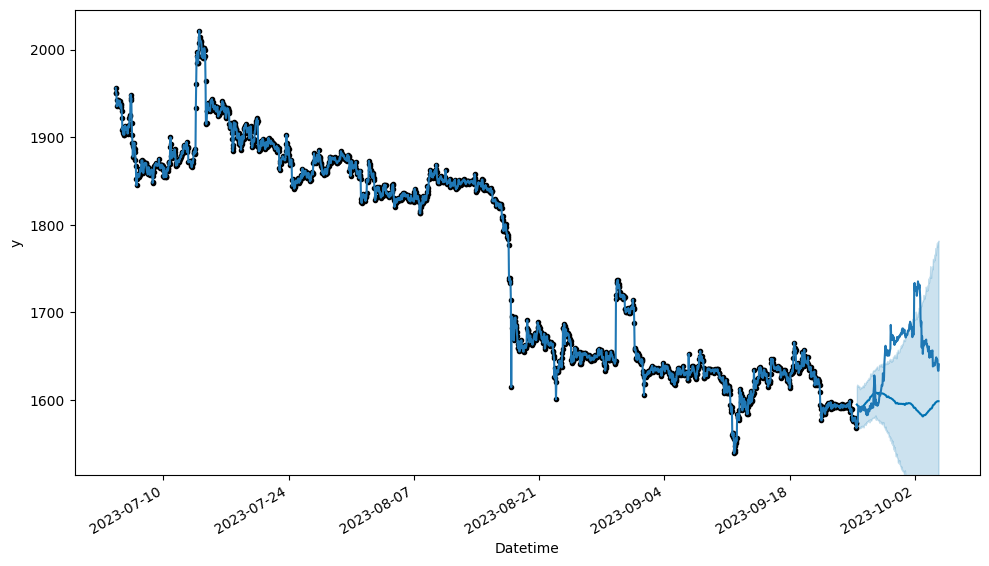

In [37]:
model.plot(testmodel_forecast)
eth.close.plot()

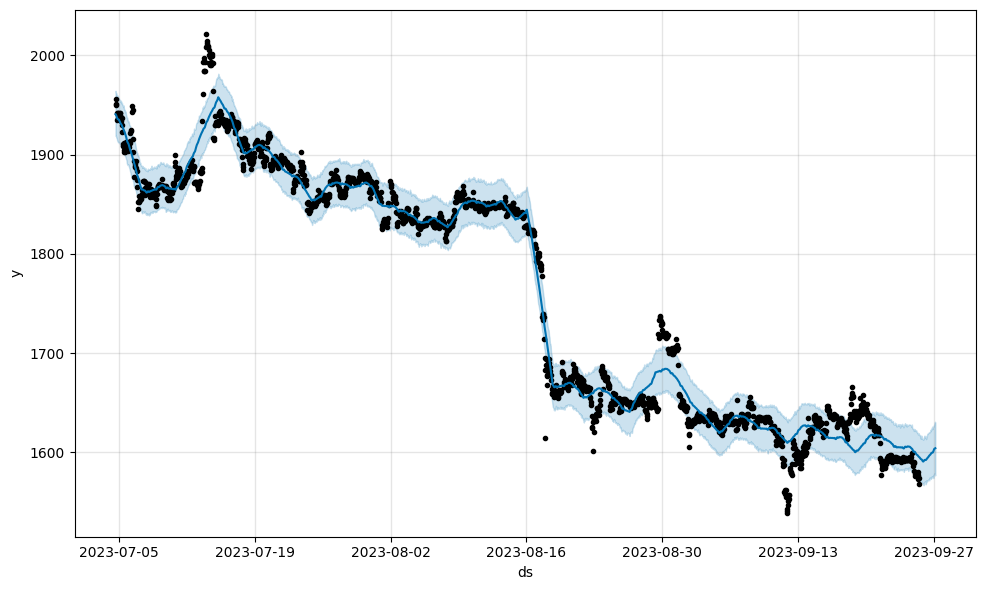

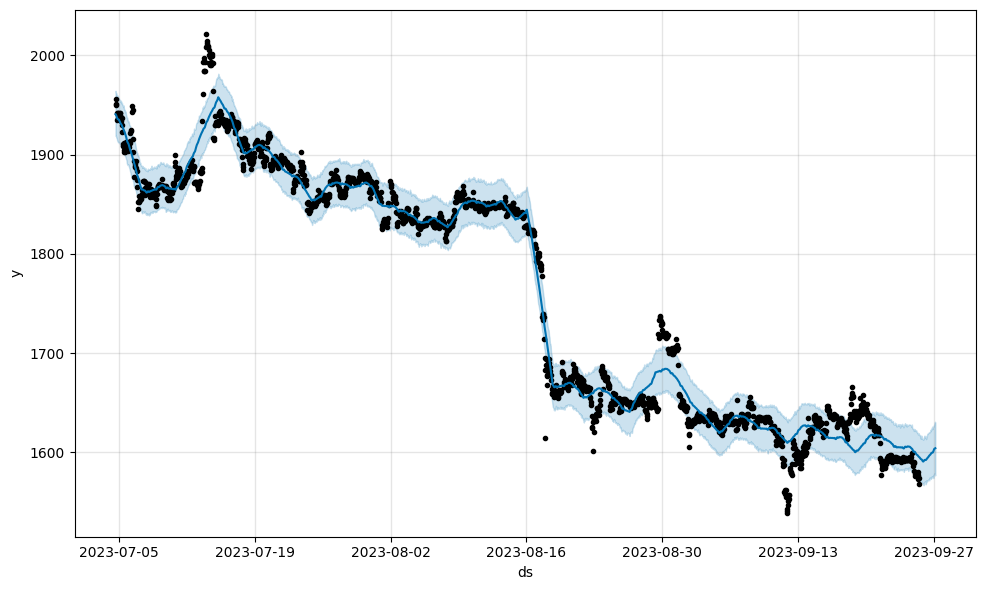

In [38]:
m.plot(forecast)

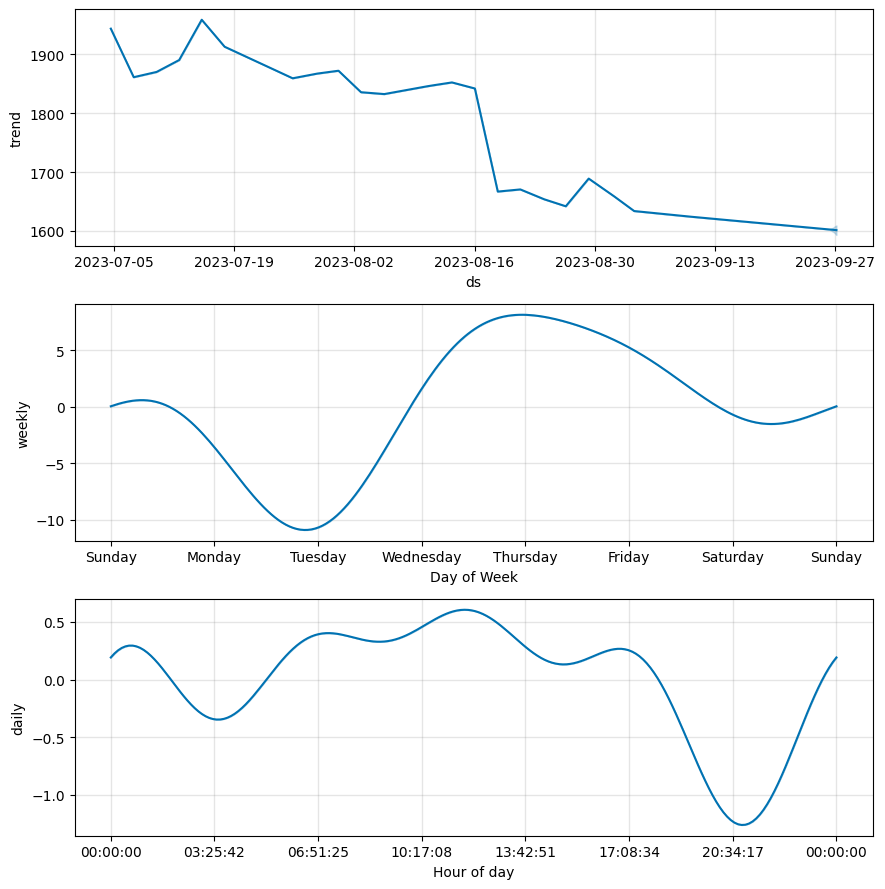

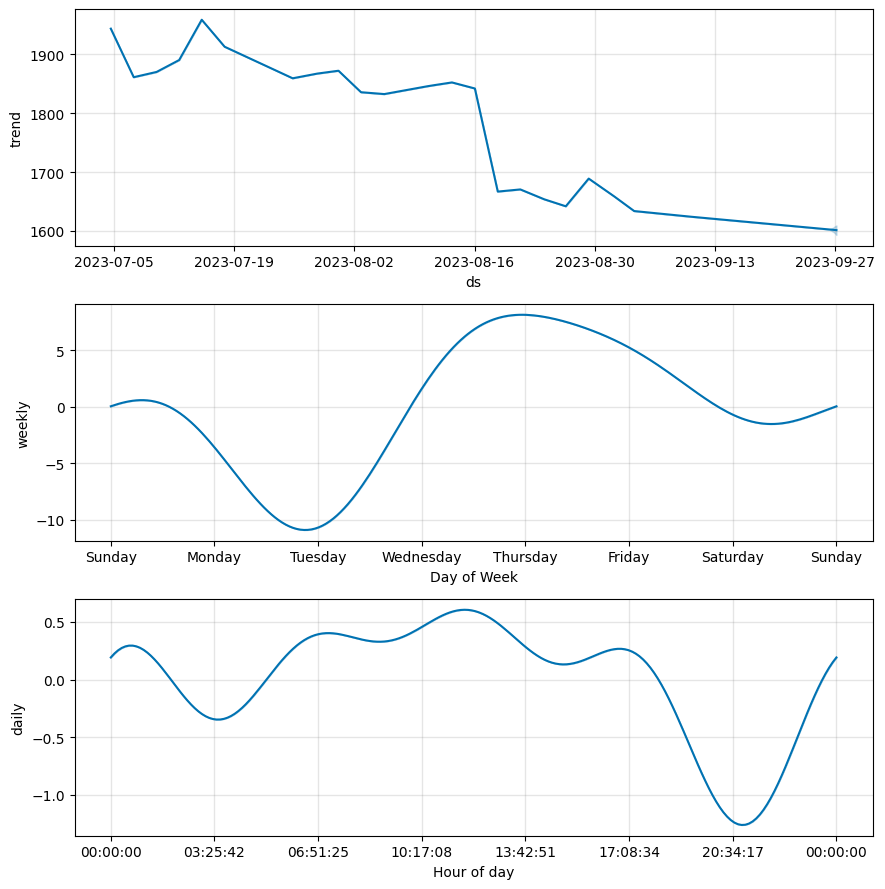

In [39]:
m.plot_components(forecast)